In [1]:
import numpy as np
from util.guided_ot import *
from util.pqdict import pqdict
from util.simplicial_paths import *
from util.alg_perf import dijkstra_tree, plot_proj_diffs

# Easy Examples

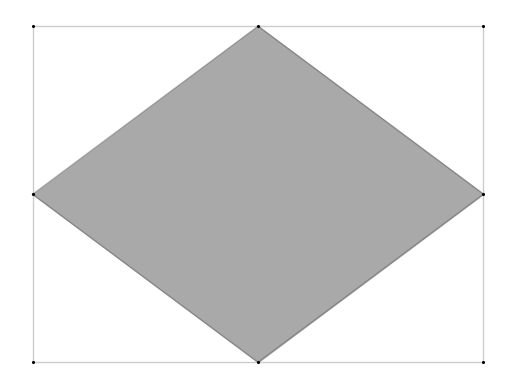

[-1. -1.] [ 0. -1.] [0.20412415]
[-1. -1.] [-1.  0.] [-0.20412415]
[ 0. -1.] [-1.  0.] [-0.40824829]
[ 0. -1.] [1. 0.] [0.40824829]
[ 0. -1.] [ 1. -1.] [0.20412415]
[ 1. -1.] [1. 0.] [0.20412415]
[-1.  0.] [0. 1.] [-0.40824829]
[-1.  0.] [-1.  1.] [-0.20412415]
[1. 0.] [0. 1.] [0.40824829]
[1. 0.] [1. 1.] [0.20412415]
[-1.  1.] [0. 1.] [-0.20412415]
[0. 1.] [1. 1.] [-0.20412415]


In [58]:
pts = generate_pts(0, 3)
SC = SimplicialComplex(pts, True)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.remove_simplices({0:set([4])})
SC.plot()
plt.show()

for i, idx in enumerate(np.where(SC.edge_vec > 0)[0]):
    print(SC.nodes[SC.edges[idx][0]], SC.nodes[SC.edges[idx][1]], SC.H[:,i])

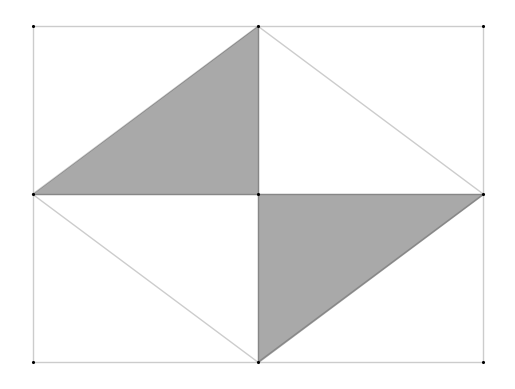

[-1. -1.] [ 0. -1.] [0.15835228 0.04135541]
[-1. -1.] [-1.  0.] [-0.15835228 -0.04135541]
[ 0. -1.] [-1.  0.] [-0.31670456 -0.08271082]
[ 0. -1.] [0. 0.] [-0.04893614 -0.46031616]
[ 0. -1.] [1. 0.] [0.34932865 0.38958827]
[ 0. -1.] [ 1. -1.] [0.17466433 0.19479413]
[ 1. -1.] [1. 0.] [0.17466433 0.19479413]
[-1.  0.] [0. 0.] [ 0.26776842 -0.37760534]
[-1.  0.] [0. 1.] [-0.49521683  0.16902607]
[-1.  0.] [-1.  1.] [-0.24760842  0.08451303]
[0. 0.] [1. 0.] [-0.04893614 -0.46031616]
[0. 0.] [0. 1.] [ 0.26776842 -0.37760534]
[1. 0.] [0. 1.] [0.31670456 0.08271082]
[1. 0.] [1. 1.] [0.15835228 0.04135541]
[-1.  1.] [0. 1.] [-0.24760842  0.08451303]
[0. 1.] [1. 1.] [-0.15835228 -0.04135541]


In [59]:
pts = generate_pts(0, 3)
SC = SimplicialComplex(pts, True)
all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.remove_simplices({2:set([4,2])})
SC.plot()
plt.show()

for i, idx in enumerate(np.where(SC.edge_vec > 0)[0]):
    print(SC.nodes[SC.edges[idx][0]], SC.nodes[SC.edges[idx][1]], SC.H[:,i])

In [22]:
for x in [SC.node_vec, SC.edge_vec, SC.face_vec]:
    print(x)

[1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 0 0 1 1 1 1 1]
[1 1 0 0 1 1]


In [21]:
print("Harmonic Projection Matrix:")
print(SC.node_vec, SC.edge_vec, SC.face_vec)

Harmonic Projection Matrix:
[1 1 1 1 1 1 1 1] [1 1 1 1 1 0 0 0 1 1 1 1 1] [1 1 0 0 1 1]


# alpha experiment

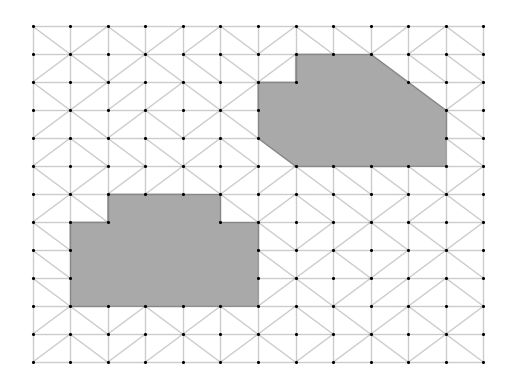

In [102]:
n_side, point_gen_mode = 13, 0

r1, r2 = 0.6, 0.3
n_holes = 2
angle = 2 * np.pi / n_holes
phase = np.pi/4
hole_locs = [(r1 * np.cos(angle * i + phase), r1 * np.sin(angle * i + phase)) for i in range(n_holes)]
hole_locs += np.array([0.0, 0.05])

# Initialize Simplicial Complex (SC)
pts = generate_pts(point_gen_mode, n_side)
SC = SimplicialComplex(pts, True)
n_side, point_gen_mode = 20, 0
start, end = 0, len(SC.node_vec)-1

all_faces = np.arange(SC.face_vec.shape[0])
faces_to_add = {2:set(all_faces)}
SC.add_simplices(faces_to_add)
SC.make_holes(hole_locs, r2)
SC.plot()

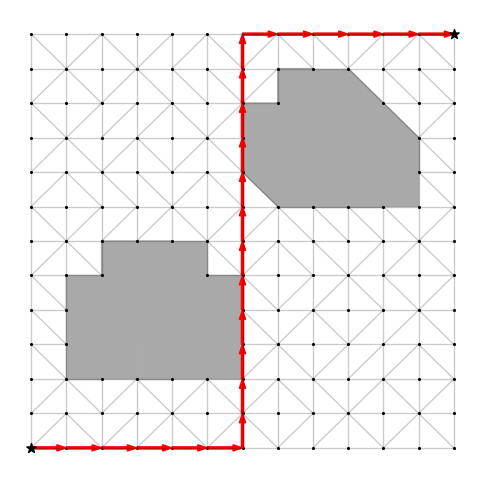

In [103]:
ref_path_coords = [(-1,-1), (0,-1), (0,1), (1,1)]
num_paths, num_nodes = 1, 1

ref_path_class = Trajectory_Class(SC)
ref_path_class.generate_paths(ref_path_coords, num_paths, num_nodes, 1e-1)
ref_path = ref_path_class.paths[0]
ref_path_proj = ref_path.edge_projections[-1]
ref_path_class.plot_paths('red', 'reference')

In [104]:
def augmented_dijkstra_v4(SC, start, end, ref_path, alpha,  num_extra=0, other=False):
    def backtrace(prev, start, end):
        path, node = [], end
        while node != start:
            path.append(node)
            node = prev[node]
        path.append(node) 
        path.reverse()
        return path
    
    def get_next_proj(u, v, curr_proj):
        edge = Trajectory(SC, [u,v], num_extra)
        proj = edge.edge_projections[1] # idx 0 is zero vec, idx 1 is edge proj
        next_proj = curr_proj + proj
        return next_proj

    def proj_cost(proj, ref_proj):
        proj_diff = np.linalg.norm(proj - ref_proj, 1)
        return np.round(proj_diff, 16)

    def cost(u, v, proj, edge_weight, proj_diff_sum, ref_proj):
        edge_cost = SC.graph[u][v]['weight']
        next_edge_weight = edge_weight + edge_cost
        next_proj = get_next_proj(u, v, proj)
        next_proj_diff = proj_cost(next_proj, ref_proj)
        next_proj_diff_sum = proj_diff_sum + next_proj_diff
        potential_cost = next_edge_weight + alpha * next_proj_diff_sum
        return potential_cost, next_proj, next_edge_weight, next_proj_diff_sum
    
    def get_ref_proj(idx):
        if 0 <= idx < len(ref_path.path_edges):
            proj = ref_path.edge_projections[idx]
        elif idx < 0:
            proj = np.inf * np.ones(dim_proj)
        else:
            proj = ref_path.edge_projections[-1]
        return proj

    def init():
        prev = {}
        edge_sum = {v:np.inf for v in range(SC.node_vec.shape[0])}
        proj_diff_sum = {v:np.inf for v in range(SC.node_vec.shape[0])}
        dist2src = {v:-1 for v in range(SC.node_vec.shape[0])}
        cost_dict = {v:np.inf for v in range(SC.node_vec.shape[0])}
        node_proj = {v:np.inf * np.ones(dim_proj) for v in range(SC.node_vec.shape[0])}

        visited = set()
        pq = pqdict()

        for i  in np.where(SC.node_vec == 1)[0]:
            pq[i] = float("inf") if (i != start) else 0

        dist2src[start], edge_sum[start] = 0, 0, 
        node_proj[start], cost_dict[start] = np.zeros(dim_proj), 0    
        proj_diff_sum[start] = 0

        return prev, edge_sum, proj_diff_sum, dist2src, cost_dict, node_proj, visited, pq

    dim_proj = (SC.H.shape[0] + num_extra) if (num_extra > 0) else SC.H.shape[0]
    prev, edge_sum, proj_diff_sum, dist2src, cost_dict, node_proj, visited, pq = init()

    node_children = {node:0 for node in np.where(SC.node_vec == 1)[0]}


    while len(pq) > 0:
        u = pq.pop()
        proj_u = node_proj[u]
        weight_u = edge_sum[u]
        n_edges_u = dist2src[u]
        proj_diff_sum_u = proj_diff_sum[u]
        visited.add(u)
        n_edges_v = n_edges_u + 1        

        num_children = 0

        for v in SC.graph.neighbors(u): # v = neighbor of lowest cost node u
            if v in visited: # node must not have already been visited
                continue

            ref_proj = get_ref_proj(n_edges_v)
            new_cost, new_proj_v, new_edge_sum_v, next_proj_diff_sum_v = cost(u, v, proj_u, weight_u, proj_diff_sum_u, ref_proj)
            old_cost = cost_dict[v]

            if u == 110:
                proj_diff = np.linalg.norm(new_proj_v - ref_proj, 1)
                print(f"(u, v, end) = {(u,v,end)}, edge weight = {SC.graph[u][v]['weight']}")
                print(f"Projections: {new_proj_v, ref_proj, ref_path.edge_projections[-1]}, proj_diff = {proj_diff}")
                print(f"ratio x alpha = {alpha * proj_diff/edge_weight}")

            if new_cost < old_cost:
                if v in prev:
                    node_children[prev[v]] -= 1
                num_children += 1
                edge_weight = new_edge_sum_v - edge_sum[u]
                cost_dict[v] = new_cost
                prev[v] = u
                edge_sum[v] = new_edge_sum_v
                node_proj[v] = new_proj_v
                dist2src[v] = n_edges_v
                proj_diff_sum[v] = next_proj_diff_sum_v
                pq[v] = new_cost
            
        node_children[u] = num_children

    path = Trajectory(SC, backtrace(prev, start, end), num_extra)

    heads = [node for node in node_children if not node_children[node]]

    other_paths = [Trajectory(SC, backtrace(prev, start, head), num_extra) for head in heads if head != end]

    if not other:
        return path
    else:
        return path, other_paths

In [105]:
def get_max_alpha_for_ref(SC, ref_path):
    ratios = []
    path_len = len(ref_path.nodes)

    for i in range(path_len-1):
        node, next = ref_path.nodes[i], ref_path.nodes[i+1]
        true_next_weight = SC.graph[node][next]['weight']
        true_next_proj = ref_path.edge_projections[i+1]
        for neighbor in SC.graph.neighbors(node):
            if (neighbor == next):
                print("PASSING")
                continue
            curr_proj = ref_path.edge_projections[i]
            step_proj = Trajectory(SC, [node, neighbor]).edge_projections[-1]
            next_proj = curr_proj + step_proj
            curr_weight = SC.graph[node][neighbor]['weight']
            print(true_next_weight , curr_weight)
            weight_diff = np.round(true_next_weight - curr_weight, 12)
            if weight_diff < 0:
                continue
            proj_diff = np.linalg.norm(next_proj - true_next_proj, ord=1)
            print((node, next), (node, neighbor), weight_diff,  proj_diff)
            ratio = weight_diff / proj_diff
            print(ratio)
            ratios.append(ratio)
    
    return ratios

get_max_alpha_for_ref(SC, ref_path)                

PASSING
0.16666666666666663 0.23570226039551578
0.16666666666666663 0.16666666666666663
(0, 1) (0, 13) 0.0 0.08531733656827327
0.0
0.16666666666666663 0.16666666666666663
(1, 2) (1, 0) 0.0 0.09824549764592845
0.0
PASSING
0.16666666666666663 0.16666666666666663
(1, 2) (1, 14) 0.0 0.08635761297866534
0.0
0.16666666666666674 0.16666666666666663
(2, 3) (2, 1) 0.0 0.17180603527108573
0.0
PASSING
0.16666666666666674 0.23570226039551587
0.16666666666666674 0.16666666666666663
(2, 3) (2, 15) 0.0 0.13975463418817258
0.0
0.16666666666666674 0.23570226039551578
0.16666666666666663 0.16666666666666674
(3, 4) (3, 2) -0.0 0.19043208934983596
-0.0
0.16666666666666663 0.16666666666666663
(3, 4) (3, 16) 0.0 0.1233288021005747
0.0
PASSING
0.16666666666666663 0.23570226039551578
0.16666666666666663 0.16666666666666663
(4, 5) (4, 3) 0.0 0.1672016542712792
0.0
PASSING
0.16666666666666663 0.16666666666666663
(4, 5) (4, 17) 0.0 0.09392203568171305
0.0
0.16666666666666674 0.16666666666666663
(5, 6) (5, 4) 0.0

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0]

(u, v, end) = (110, 98, 168), edge weight = 0.23570226039551578
Projections: (array([-0.13575522, -0.83457098]), array([-0.37977677, -0.95245869]), array([-1.21036032, -0.852474  ])), proj_diff = 0.3619092559881
ratio x alpha = 12.283607476001462
(u, v, end) = (110, 109, 168), edge weight = 0.16666666666666674
Projections: (array([-0.29046865, -0.95144581]), array([-0.37977677, -0.95245869]), array([-1.21036032, -0.852474  ])), proj_diff = 0.09032099770511748
ratio x alpha = 3.065596318119514
(u, v, end) = (110, 122, 168), edge weight = 0.23570226039551595
Projections: (array([-0.3716068 , -0.97174509]), array([-0.37977677, -0.95245869]), array([-1.21036032, -0.852474  ])), proj_diff = 0.027456366235659058
ratio x alpha = 0.931899972094843
(u, v, end) = (110, 123, 168), edge weight = 0.16666666666666674
Projections: (array([-0.37977677, -0.95245869]), array([-0.37977677, -0.95245869]), array([-1.21036032, -0.852474  ])), proj_diff = 0.0
ratio x alpha = 0.0


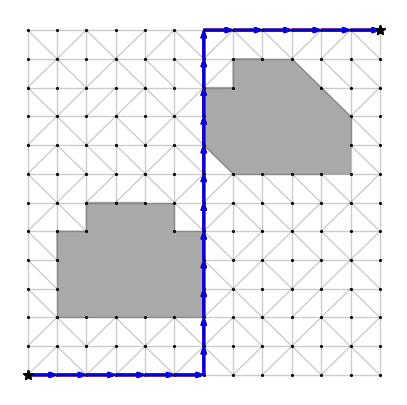

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0-1-2-3-4-5-6-19-32-45-58-71-84-97-110-123-136-149-162-163-164-165-166-167-168
[[ 0.00000000e+00  0.00000000e+00]
 [-5.63424135e-17 -3.67111274e-02]
 [ 3.59851277e-06 -9.82418991e-02]
 [ 7.84571485e-05 -2.08438706e-01]
 [ 3.67834292e-04 -2.88309753e-01]
 [ 1.05940583e-03 -3.74659411e-01]
 [ 3.44573283e-03 -4.55396701e-01]
 [ 1.28064795e-03 -4.69039130e-01]
 [-7.76122980e-03 -5.36922599e-01]
 [-2.45276248e-02 -6.23847767e-01]
 [-5.05131403e-02 -6.94959383e-01]
 [-1.12490205e-01 -7.94170821e-01]
 [-1.53545982e-01 -8.43061837e-01]
 [-2.19493159e-01 -8.96905563e-01]
 [-2.79420118e-01 -9.21425227e-01]
 [-3.79776766e-01 -9.52458692e-01]
 [-4.88303383e-01 -9.64205761e-01]
 [-5.63963923e-01 -9.61422871e-01]
 [-5.87431643e-01 -9.60213767e-01]
 [-6.91857847e-01 -9.39208619e-01]
 [-8.81635084e-01 -9.07081223e-01]
 [-1.00183023e+00 -8.87069426e-01]
 [-1.09643730e+00 -8.71357195e-01]
 [-1.18778337e+00 -8.56215894e-01]
 [-1.21036032e+00 -8.52473996e-01]]
[[ 0.00000000e+00  0.00000000e+00]
 [-5.63424

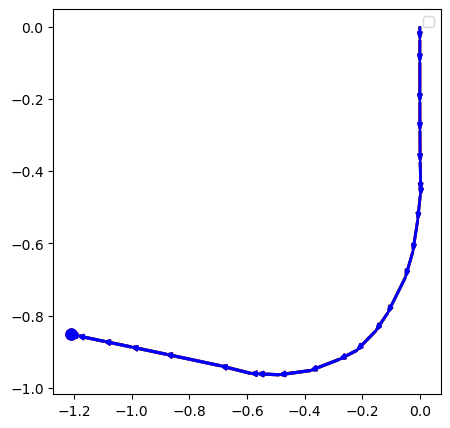

In [107]:
alpha = 8
path, other_paths = augmented_dijkstra_v4(SC, start, end, ref_path, alpha, 0, True)
dijkstra_tree(SC, path, [path], ref_path_class, plot_others=True)